### **Training MobileNet**

In [20]:
 !git clone https://github.com/naitik7jain/Tomato-Diseases-Detection.git


fatal: destination path 'Tomato-Diseases-Detection' already exists and is not an empty directory.


In [21]:

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import matplotlib.pyplot as plt


In [22]:
# Path
train_dir = "Tomato-Diseases-Detection/train"
val_dir = "Tomato-Diseases-Detection/val"

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 10  # 9 diseases + 1 healthy


In [23]:

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)



Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [24]:
#  Normalize images to [0,1]
rescale = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

#  MobileNetV2 base model
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet")
base_model.trainable = False  # freeze base



In [25]:
#  Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


#  Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#  Training the model
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

#  Save model
model.save("tomato_disease_model.h5")
print(" Model saved as tomato_disease_model.h5")

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 0.5146 - loss: 1.4539 - val_accuracy: 0.7750 - val_loss: 0.7076
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 417s 1s/step - accuracy: 0.8140 - loss: 0.5801 - val_accuracy: 0.8140 - val_loss: 0.5923
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 435s 1s/step - accuracy: 0.8444 - loss: 0.4646 - val_accuracy: 0.8440 - val_loss: 0.5218
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.8727 - loss: 0.4034 - val_accuracy: 0.8450 - val_loss: 0.5062
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.8806 - loss: 0.3753 - val_accuracy: 0.8410 - val_loss: 0.5030
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.8898 - loss: 0.3444 - val_accuracy: 0.8520 - val_loss: 0.4720
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 448s 1s/step - accuracy: 0.8931 - loss: 0.3247 - val_accuracy: 0.8660 - val_loss: 0.4447
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 0.9024 - loss: 0.3038 - val_accu

 Model saved as tomato_disease_model.h5


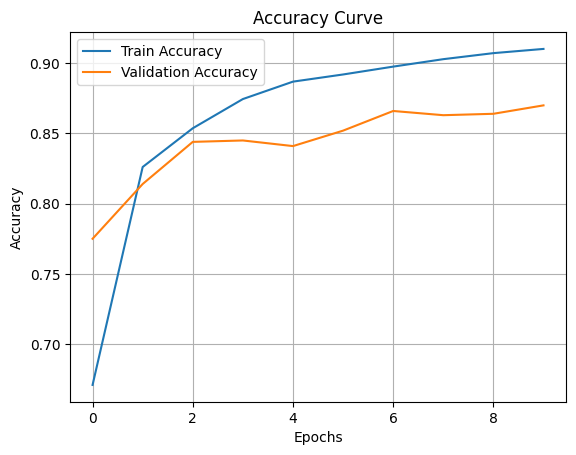

In [26]:
# Plot accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## **Testing**

In [27]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from tensorflow.keras.models import load_model

🔗 Enter the image URL: https://content.ces.ncsu.edu/media/images/IMG_1302.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


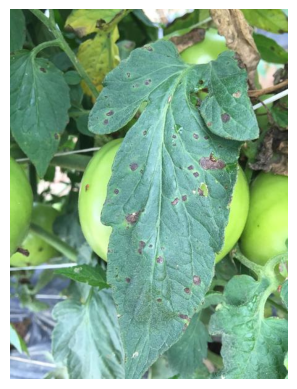

📊 Top 3 Predicted Diseases:
➡️ Late Blight (Index 2): 88.07%
➡️ Early Blight (Index 1): 11.47%
➡️ Bacterial Spot (Index 0): 0.39%


In [28]:

# Load model
model = load_model("tomato_disease_model.h5")
class_names = [
    "Bacterial Spot", "Early Blight", "Late Blight", "Leaf Mold",
    "Septoria Leaf Spot", "Spider Mites", "Target Spot",
    "Tomato Mosaic Virus", "Tomato Yellow Leaf Curl Virus", "Healthy"
]

# Ask for URL
image_url = input("🔗 Enter the image URL: ").strip()

# Download and preprocess
def preprocess_image_from_url(url):
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, stream=True)
        response.raise_for_status()

        if 'image' not in response.headers.get('Content-Type', ''):
            raise ValueError("URL did not return an image")

        image = Image.open(BytesIO(response.content)).convert("RGB")
        resized = image.resize((224, 224))
        img_array = np.array(resized) / 255.0
        return image, np.expand_dims(img_array, axis=0)  # original + model-ready
    except Exception as e:
        print(" Error loading image:", e)
        return None, None

# Run prediction
original_img, input_data = preprocess_image_from_url(image_url)

if input_data is not None:
    prediction = model.predict(input_data)
    predicted_class = np.argmax(prediction)

    # Display the image
    plt.imshow(original_img)
    plt.axis("off")
    plt.show()

    # Top 3 predictions
    print("📊 Top 3 Predicted Diseases:")
    top_indices = prediction[0].argsort()[-3:][::-1]
    for i in top_indices:
        confidence = prediction[0][i] * 100
        print(f"➡️ {class_names[i]} (Index {i}): {confidence:.2f}%")
else:
    print("⚠️ Prediction skipped due to image load error.")
